In [1]:
import sys
sys.path.append("..")

import matplotlib.pyplot as plt
import numpy as np
import tqdm

from dataset import *
from midi_unit import *
from similarity import *
from util import *

In [2]:
generator = new_generator(root="../../dataset/newbie-dataset/", slice_duration=3.0, mark_onset=False, shuffle=True, verbose=True)

In [3]:
((score_matrix, perf_matrix, (original_head, original_tail)), (perf_path, _, _)) = next(generator)

In [4]:
decay_fn = make_decay_fn("linear", settling_frame=3)
# decay_fn = lambda x: x
score_seq_list = MIDIUnitSeqList.from_midi_matrix(score_matrix, decay_fn)
perf_seq_list = MIDIUnitSeqList.from_midi_matrix(perf_matrix, decay_fn)

score_sequence = score_seq_list.repr_sequence
perf_sequence = perf_seq_list.repr_sequence
original_sequence = perf_seq_list[original_head:original_tail+1].repr_sequence

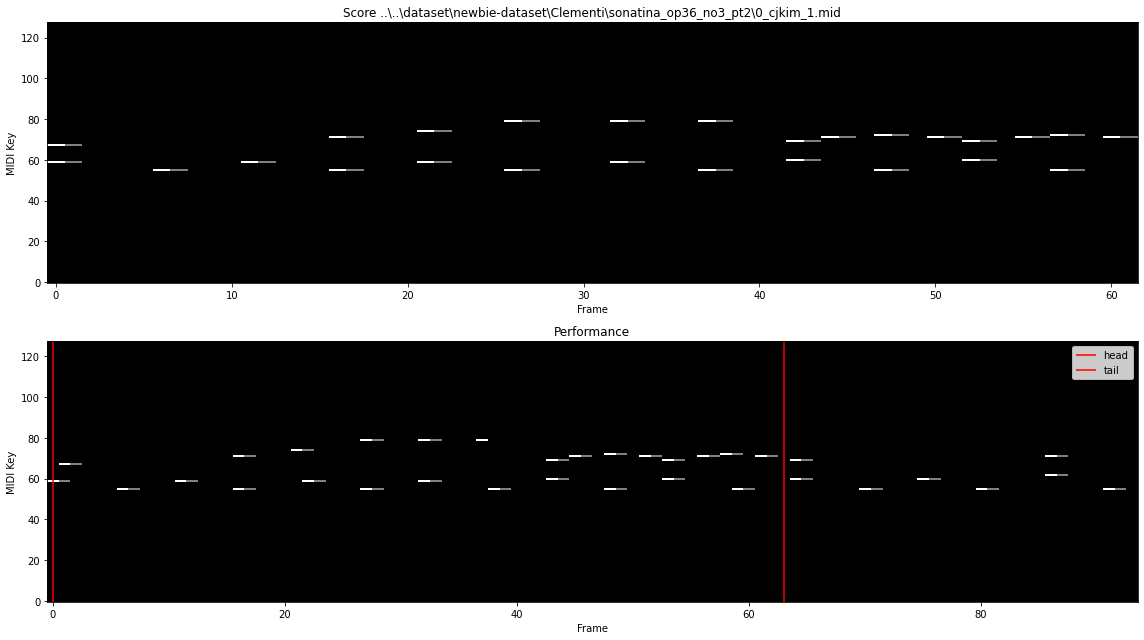

In [5]:
decayed_score_matrix = score_seq_list.to_midi_matrix(set_velocity=True)
decayed_perf_matrix = perf_seq_list.to_midi_matrix(set_velocity=True)

plot_midi_matrices(decayed_score_matrix, decayed_perf_matrix,
                   (original_head, original_tail),
                   title1="Score %s" % perf_path,
                   title2="Performance")

In [6]:
original_cost, _, _, original_path = global_dtw(score_sequence, original_sequence)
global_cost, (global_head, global_tail), _, global_path = global_dtw(score_sequence, perf_sequence)
subsequence_cost, (subsequence_head, subsequence_tail), subsequence_matrix, subsequence_path = subsequence_dtw(score_sequence, perf_sequence)

original_path = np.array([(original_head+x, y) for (x, y) in original_path])
global_path = np.array([(x, y) for (x, y) in global_path])
subsequence_path = np.array([(x, y) for (x, y) in subsequence_path])

print(f"{original_cost=:.2f}")
print(f"{global_cost=:.2f}")
print(f"{subsequence_cost=:.2f}")

original_cost=0.13
global_cost=0.29
subsequence_cost=0.10


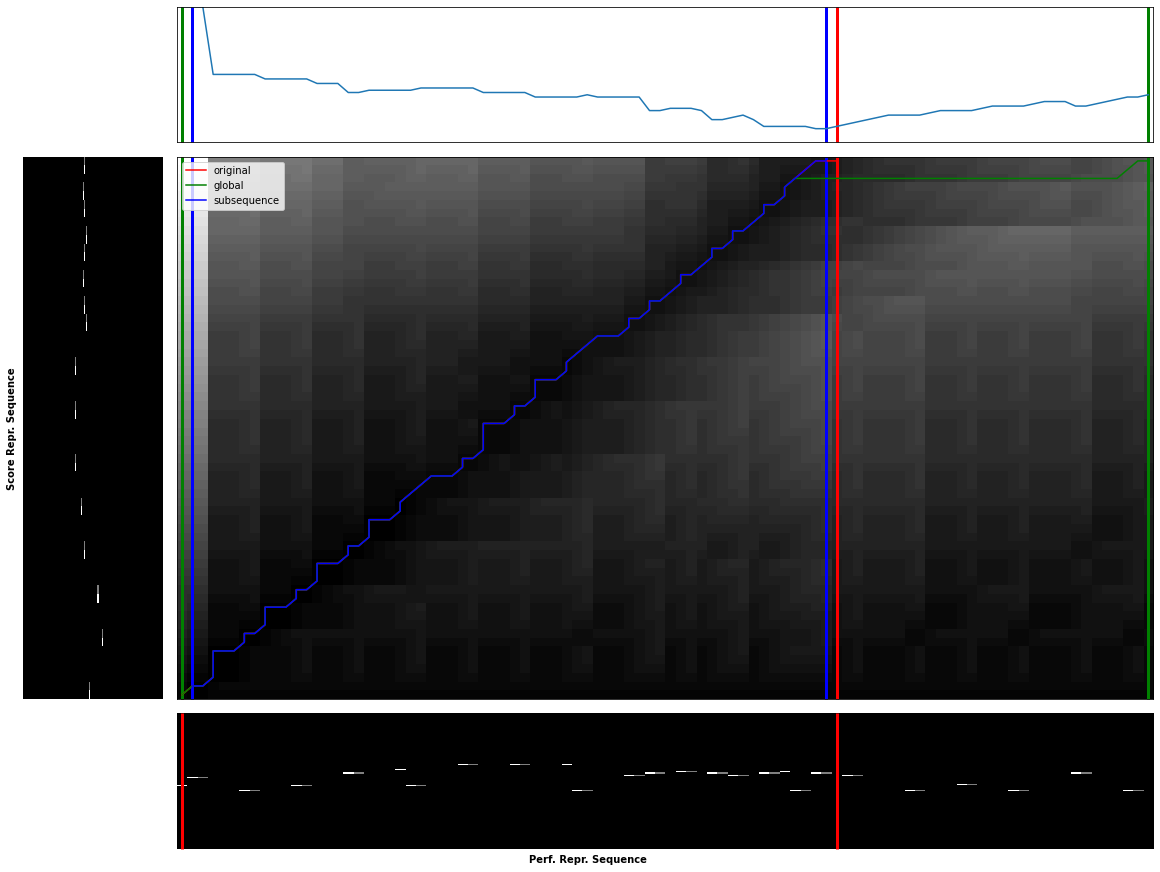

In [7]:

score_sequence_matrix = score_sequence.to_midi_matrix(set_velocity=True)
score_sequence_matrix = np.rot90(score_sequence_matrix, axes=(1, 0))
perf_sequence_matrix = perf_sequence.to_midi_matrix(set_velocity=True)

num_score_frame, num_perf_frame = subsequence_matrix.shape
delta_functions = subsequence_matrix[-1, :]
delta_max = np.max(delta_functions)

fig, axes = plt.subplots(3, 2, gridspec_kw = {"width_ratios": [1, 7], "height_ratios": [1, 4, 1]}, facecolor="white", figsize=(16, 12))
fig.text(0.5, 0, "Perf. Repr. Sequence", ha="center", va="center", fontdict={"weight":"semibold"})
fig.text(0, 0.5, "Score Repr. Sequence", ha="center", va="center", rotation="vertical", fontdict={"weight":"semibold"})

axes[0][0].axis("off")  # hide

axes[0][1].plot(delta_functions)
axes[0][1].vlines(original_head, 0, delta_max, "r", linewidth=3, clip_on=False)
axes[0][1].vlines(original_tail, 0, delta_max, "r", linewidth=3, clip_on=False)
axes[0][1].vlines(global_head, 0, delta_max, "g", linewidth=3, clip_on=False)
axes[0][1].vlines(global_tail, 0, delta_max, "g", linewidth=3, clip_on=False)
axes[0][1].vlines(subsequence_head, 0, delta_max, "b", linewidth=3, clip_on=False)
axes[0][1].vlines(subsequence_tail, 0, delta_max, "b", linewidth=3, clip_on=False)
axes[0][1].set_xlim([-0.5, num_perf_frame - 0.5])
axes[0][1].set_ylim([0, delta_max])
axes[0][1].xaxis.set_visible(False)
axes[0][1].yaxis.set_visible(False)

axes[1][0].imshow(score_sequence_matrix, cmap="gray", aspect="auto", origin="lower", interpolation="nearest")
axes[1][0].set_xlim([0, MAX_MIDI_KEY])
axes[1][0].set_ylim([-0.5, num_score_frame - 0.5])
axes[1][0].axis("off")

axes[1][1].imshow(subsequence_matrix, cmap="gray", aspect="auto", origin="lower", interpolation="nearest")
axes[1][1].vlines(original_head, -0.5, num_score_frame - 0.5, "r", linewidth=3, clip_on=False)
axes[1][1].vlines(original_tail, -0.5, num_score_frame - 0.5, "r", linewidth=3, clip_on=False)
axes[1][1].vlines(global_head, -0.5, num_score_frame - 0.5, "g", linewidth=3, clip_on=False)
axes[1][1].vlines(global_tail, -0.5, num_score_frame - 0.5, "g", linewidth=3, clip_on=False)
axes[1][1].vlines(subsequence_head, -0.5, num_score_frame - 0.5, "b", linewidth=3, clip_on=False)
axes[1][1].vlines(subsequence_tail, -0.5, num_score_frame - 0.5, "b", linewidth=3, clip_on=False)
axes[1][1].plot(original_path[:, 0], original_path[:, 1], "r", clip_on=False, label="original")
axes[1][1].plot(global_path[:, 0], global_path[:, 1], "g", clip_on=False, label="global")
axes[1][1].plot(subsequence_path[:, 0], subsequence_path[:, 1], "b", clip_on=False, label="subsequence")
axes[1][1].legend()
axes[1][1].set_xlim([-0.5, num_perf_frame - 0.5])
axes[1][1].set_ylim([-0.5, num_score_frame - 0.5])
axes[1][1].xaxis.set_visible(False)
axes[1][1].yaxis.set_visible(False)

axes[2][0].axis("off")  # hide

axes[2][1].imshow(perf_sequence_matrix, cmap="gray", aspect="auto", origin="lower", interpolation="nearest")
axes[2][1].vlines(original_head, 0, MAX_MIDI_KEY, "r", linewidth=3, clip_on=False)
axes[2][1].vlines(original_tail, 0, MAX_MIDI_KEY, "r", linewidth=3, clip_on=False)
axes[2][1].set_xlim([-0.5, num_perf_frame - 0.5])
axes[2][1].set_ylim([0, MAX_MIDI_KEY])
axes[2][1].axis("off")

plt.tight_layout()
plt.show()

In [12]:
# For asap-dataset
# dataset_root = "../../dataset/asap-dataset"
# score_prefix = "midi_score"

# For newbie-dataset
dataset_root = "../../dataset/newbie-dataset"
score_prefix = "score"
slice_duration = [2.0, 5.0]
expansion_rate = [1.1, 3.0]
frames_per_second = 20 # Hz
settling_frame = 3

num_samples = 100

generator = new_generator(root=dataset_root,
                          score_prefix=score_prefix,
                          slice_duration=slice_duration,
                          expansion_rate=expansion_rate,
                          frames_per_second=frames_per_second,
                          mark_onset=True, shuffle=True, verbose=True)

decay_fn = make_decay_fn("linear", settling_frame=settling_frame)

threshold = 0.85

In [13]:
accuracies = []
precisions = []
recalls = []
f1_scores = []
ious = []

wrong_entries = []

generator = tqdm.tqdm(generator, total=num_samples)
description = "[%d] accuracy: %.4f, f1_score: %.4f, iou: %.4f"
generator.set_description(description % (0, -1, -1, -1))
for idx, ((score_matrix, perf_matrix, original_alignment), (perf_path, slice_duration, expansion_rate)) in enumerate(generator):
    score_seqlist = MIDIUnitSeqList.from_midi_matrix(score_matrix, decay_fn)
    perf_seqlist = MIDIUnitSeqList.from_midi_matrix(perf_matrix, decay_fn)
    score_repr_sequence = score_seqlist.repr_sequence
    perf_repr_sequence = perf_seqlist.repr_sequence
    _, subsequence_alignment, *_ = subsequence_dtw(score_repr_sequence, perf_repr_sequence)
    alignment_scores = score_alignment(original_alignment, subsequence_alignment, len(perf_repr_sequence))
    accuracy = alignment_scores["accuracy"]
    precision = alignment_scores["precision"]
    recall = alignment_scores["recall"]
    f1_score = alignment_scores["f1_score"]
    iou = alignment_scores["iou"]

    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1_score)
    ious.append(iou)

    if min(accuracy, precision, recall, f1_score, iou) < threshold:
        wrong_entries.append((score_matrix, perf_matrix,
                               original_alignment,
                               subsequence_alignment,
                               perf_path,
                               slice_duration,
                               expansion_rate,
                               alignment_scores))
    
    generator.set_description(description % (idx, accuracies[-1], f1_scores[-1], ious[-1]))

[78] accuracy: 0.9963, f1_score: 0.9901, iou: 0.9804:  79%|███████▉  | 79/100 [00:10<00:02,  7.23it/s]


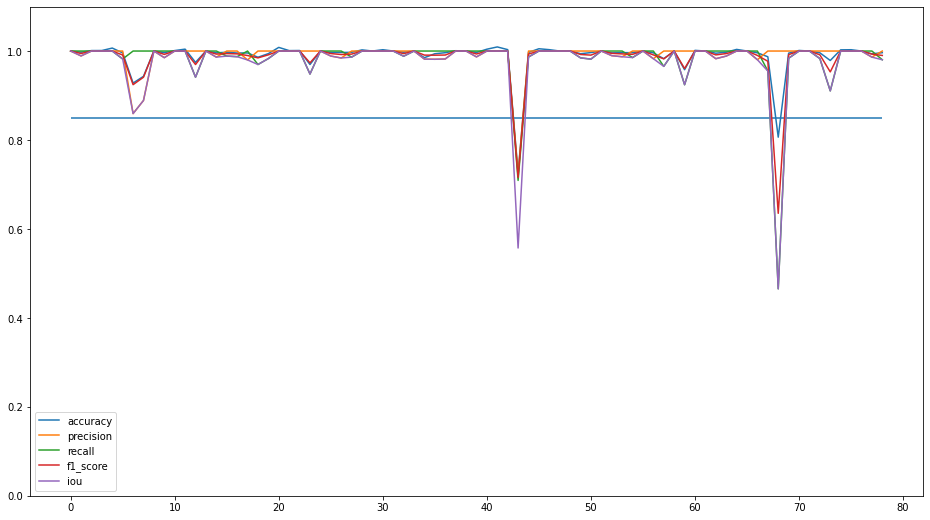

In [14]:
plt.figure(figsize=(16, 9), facecolor="white")
x = list(range(len(f1_scores)))
plt.plot(x, accuracies, label="accuracy")
plt.plot(x, precisions, label="precision")
plt.plot(x, recalls, label="recall")
plt.plot(x, f1_scores, label="f1_score")
plt.plot(x, ious, label="iou")
plt.hlines(0.85, 0, x[-1])
plt.legend()
plt.ylim(0, 1.1)
plt.show()

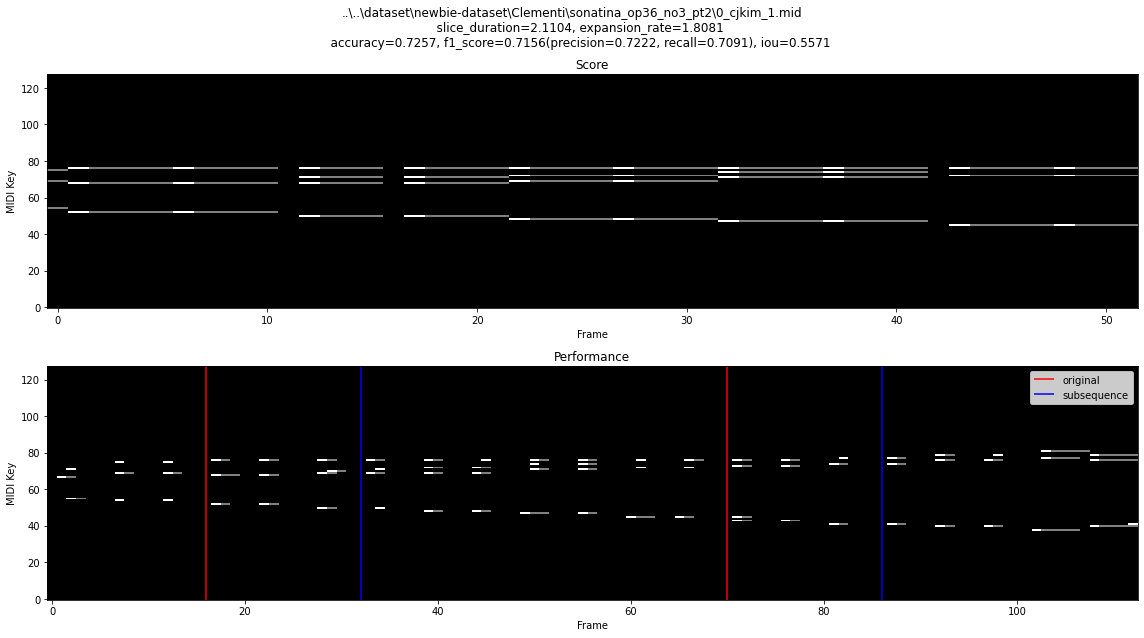

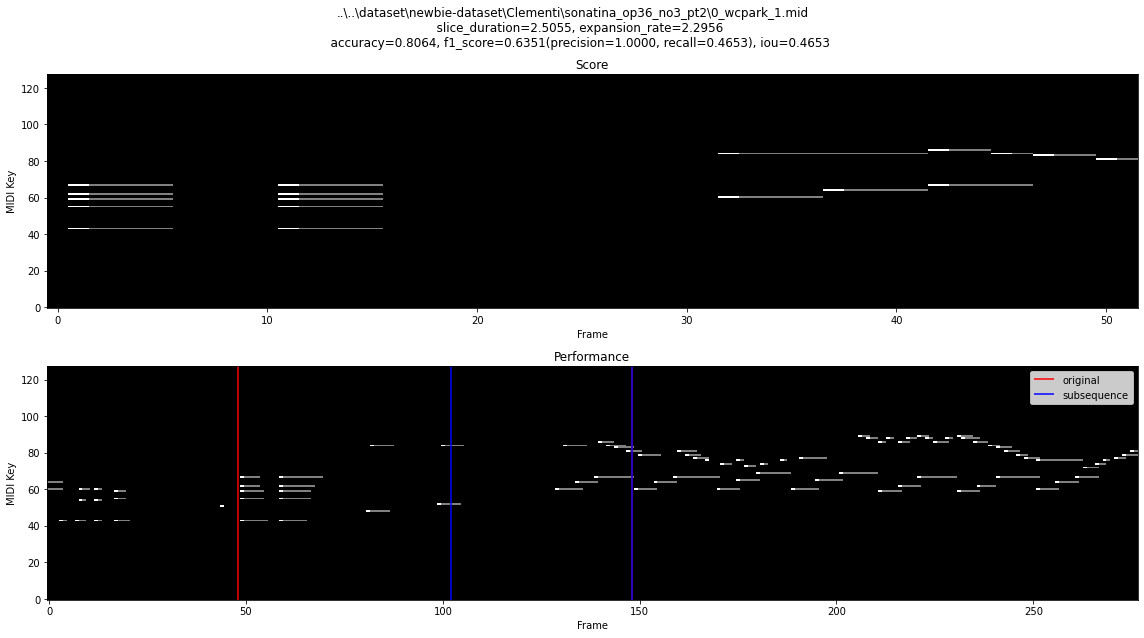

In [15]:
for score_matrix, perf_matrix, original_alignment, subsequence_alignment, perf_path, slice_duration, expansion_rate, alignment_scores in wrong_entries:
    plt.figure(figsize=(16, 9), facecolor="white")

    accuracy = alignment_scores["accuracy"]
    precision = alignment_scores["precision"]
    recall = alignment_scores["recall"]
    f1_score = alignment_scores["f1_score"]
    iou = alignment_scores["iou"]

    plt.suptitle(f"""{perf_path}
    {slice_duration=:.4f}, {expansion_rate=:.4f}
    {accuracy=:.4f}, {f1_score=:.4f}({precision=:.4f}, {recall=:.4f}), {iou=:.4f}""")

    plt.subplot(2, 1, 1)
    plt.title("Score")
    plt.imshow(score_matrix, cmap="gray", aspect="auto", origin="lower", interpolation="nearest")
    plt.ylabel("MIDI Key")
    plt.xlabel("Frame")
    ymax, xmax = score_matrix.shape
    plt.ylim([-0.5, ymax - 0.5])
    plt.xlim([-0.5, xmax - 0.5])

    plt.subplot(2, 1, 2)
    plt.title("Performance")
    plt.imshow(perf_matrix, cmap="gray", aspect="auto", origin="lower", interpolation="nearest")
    plt.ylabel("MIDI Key")
    plt.xlabel("Frame")
    ymax, xmax = perf_matrix.shape
    plt.vlines(original_alignment[0], -0.5, ymax - 0.5, "r", clip_on=False)
    plt.vlines(original_alignment[1], -0.5, ymax - 0.5, "r", clip_on=False, label="original")
    plt.vlines(subsequence_alignment[0], -0.5, ymax - 0.5, "b", clip_on=False)
    plt.vlines(subsequence_alignment[1], -0.5, ymax - 0.5, "b", clip_on=False, label="subsequence")
    plt.legend()
    plt.ylim([-0.5, ymax - 0.5])
    plt.xlim([-0.5, xmax - 0.5])

    plt.tight_layout()
    plt.show()